In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mediapipe

In [ ]:
import os
import cv2 as cv
import numpy as np
import time
import datetime
import math
import random
import time
import datetime
import mediapipe as mp

In [ ]:
#copy asanas videos
!cp -r "/content/drive/Shareddrives/Major project/Major Project/Human Activity Recognition on Yoga Dataset/Yoga dataset(6asanas)" "/content"

In [ ]:
mp_pose = mp.solutions.pose
dataset_path="/content/Yoga dataset(6asanas)"
asanas=os.listdir(dataset_path)
asanas.sort()
train=[]
#train=np.array(train)
test=[]
#test=np.array(test)
pose=mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
for asana in asanas:
  videos=os.listdir(os.path.join(dataset_path,asana))
  video_paths=[]
  for video in videos:
    if video.endswith('.mp4'):
      video_paths.append(os.path.join(dataset_path,asana,video))
  num=len(video_paths)
  testno=math.floor(0.20*float(num))
  k=random.sample(video_paths,testno)
  trainasana=[]
  testasana=[]
  for video_path in video_paths:
    past=time.time()
    v=0
    currvideo=np.zeros((33*4,))
    cam=cv.VideoCapture(video_path)
    print(video_path)
    z=0
    while(True):
      ret,frame = cam.read()
      #print(ret)
      if ret:
        if z%2==0:
          #print("pose estimation done")
          arr=np.zeros((33,4))
          results=pose.process(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
          if results.pose_landmarks is None:
            continue
          image_height, image_width, _ = frame.shape
          j=0
          for i in range(33):
            arr[i,j] = results.pose_landmarks.landmark[i].x*image_width
          j=1
          for i in range(33):
            arr[i,j] = results.pose_landmarks.landmark[i].y*image_height
          j=2
          for i in range(33):
            arr[i,j] = results.pose_landmarks.landmark[i].z*image_width
          j=3
          for i in range(33):
            arr[i][j] = results.pose_landmarks.landmark[i].visibility
          min_x=min(arr[:,0])
          max_x=max(arr[:,0])
          min_y=min(arr[:,1])
          max_y=max(arr[:,1])
          j=0
          for i in range(33):
            arr[i,j]=(256/(max_x-min_x))*(arr[i][j]-min_x)
          j=2
          for i in range(33):
            arr[i,j]=(256/(max_x-min_x))*(arr[i][j]-min_x)
          j=1
          for i in range(33):
            arr[i,j]=(256/(max_y-min_y))*(arr[i][j]-min_y)
          arr=arr.reshape(33*4,)
          currvideo=np.vstack((currvideo,arr))
          v=v+1
          #print(v)
        z=z+1
      else:
        break
    cam.release()
    if video_path in k:
      testasana.append(currvideo[1:,:])
    else:
      trainasana.append(currvideo)
    print("video pose estimation done in {0} seconds for {1} frames".format(datetime.timedelta(time.time()-past),v))
  train.append(trainasana)
  test.append(testasana)

In [ ]:
train=np.load('train.npy',allow_pickle=True)
trainXfinal=np.zeros((1,64,132))
trainYfinal=np.zeros(1)
windowsize=64
overlap_size=48  #80% overlap
for y_label,asana in enumerate(train):
  for vid in asana:
    for start in range(0,vid.shape[0]-windowsize, windowsize - overlap_size):
      currvid=vid[start:start+windowsize,:]
      currvid=currvid.reshape(1,64,132)
      assert currvid.shape==(1,64,132) ,"Something went wrong"
      #print(trainXfinal.shape,currvid.shape)
      trainXfinal=np.vstack([trainXfinal,currvid])
      trainYfinal=np.vstack([trainYfinal,np.array([y_label])])
print(trainXfinal.shape)
print(trainYfinal.shape)
np.save("trainXfinal.npy",trainXfinal)
np.save("trainYfinal.npy",trainYfinal)

In [ ]:
test=np.load('test.npy',allow_pickle=True)
testXfinal=np.zeros((1,64,132))
testYfinal=np.zeros(1)
windowsize=64
overlap_size=48  #80% overlap
for y_label,asana in enumerate(test):
  for vid in asana:
    for start in range(0,vid.shape[0]-windowsize, windowsize - overlap_size):
      currvid=vid[start:start+windowsize,:]
      currvid=currvid.reshape(1,64,132)
      assert currvid.shape==(1,64,132) ,"Something went wrong"
      #print(trainXfinal.shape,currvid.shape)
      testXfinal=np.vstack([testXfinal,currvid])
      testYfinal=np.vstack([testYfinal,np.array([y_label])])
print(testXfinal[1:,].shape)
print(testYfinal.shape)
np.save("testXfinal.npy",testXfinal)
np.save("testYfinal.npy",testYfinal)

(520, 64, 132)
(520, 1)


In [ ]:
np.save("trainXFinal.npy",trainXfinal[1:,])
np.save("trainYFinal.npy",trainYfinal[1:,])

In [ ]:
!cp -r "/content/drive/Shareddrives/Major project/Major Project/Human Activity Recognition on Yoga Dataset/Numpy Arrays" "/content"

In [ ]:
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense,Flatten,Dropout,LSTM,TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
import os
def get_model(num_len,num_features,num_outputs):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, kernel_initializer='glorot_uniform',activation='relu'), input_shape=(None,num_len,num_features)))
  model.add(TimeDistributed(Conv1D(filters=8, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100))
  model.add(Dropout(0.2))
  adam=Adam(lr=0.0001)
  model.add(Dense(num_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
  return model
def evaluate_model(trainX, trainy, testX, testy):
  num_epochs=100
  batch_size = 64
  num_ts, num_features, num_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  num_step, num_len = 4, 16
  trainX = trainX.reshape((trainX.shape[0], num_step, num_len, num_features))
  testX = testX.reshape((testX.shape[0], num_step, num_len, num_features))
  model=get_model(num_len,num_features,num_outputs)
  filepath= "weights/" +"val1" + "-{epoch:02d}-{val_acc:.4f}.hdf5"
  os.makedirs(os.path.dirname(filepath),exist_ok=True)
  checkpoint = ModelCheckpoint(filepath,save_weights_only=True,monitor='val_acc',mode='max',save_best_only=True)
  callbacks_list = [checkpoint]
  history=model.fit(trainX,trainy,validation_data=(testX,testy), epochs=num_epochs, batch_size=batch_size, verbose=2,callbacks=callbacks_list)
  return history
os.chdir("/content/Numpy Arrays")
trainX=np.load("trainXFinal.npy")
trainY=np.load("trainYFinal.npy")
testX=np.load("testXFinal.npy")
testY=np.load("testYFinal.npy")
trainY = to_categorical(trainY)
testY = to_categorical(testY)
print(trainX.shape,trainY.shape,testX.shape,testY.shape)
model_history=evaluate_model(trainX, trainY, testX, testY)

(2800, 64, 132) (2800, 6) (519, 64, 132) (519, 6)
Epoch 1/100
44/44 - 2s - loss: 1.6773 - acc: 0.3375 - val_loss: 1.5413 - val_acc: 0.4374
Epoch 2/100
44/44 - 0s - loss: 1.4995 - acc: 0.4539 - val_loss: 1.3836 - val_acc: 0.6031
Epoch 3/100
44/44 - 0s - loss: 1.4125 - acc: 0.5007 - val_loss: 1.3212 - val_acc: 0.6647
Epoch 4/100
44/44 - 0s - loss: 1.3363 - acc: 0.5375 - val_loss: 1.2273 - val_acc: 0.6724
Epoch 5/100
44/44 - 0s - loss: 1.2891 - acc: 0.5689 - val_loss: 1.1764 - val_acc: 0.7110
Epoch 6/100
44/44 - 0s - loss: 1.2567 - acc: 0.6071 - val_loss: 1.1475 - val_acc: 0.7360
Epoch 7/100
44/44 - 0s - loss: 1.2161 - acc: 0.6246 - val_loss: 1.0984 - val_acc: 0.7996
Epoch 8/100
44/44 - 0s - loss: 1.1787 - acc: 0.6550 - val_loss: 1.0302 - val_acc: 0.8902
Epoch 9/100
44/44 - 0s - loss: 1.1108 - acc: 0.7243 - val_loss: 0.9911 - val_acc: 0.8825
Epoch 10/100
44/44 - 0s - loss: 1.0735 - acc: 0.7375 - val_loss: 0.9304 - val_acc: 0.9094
Epoch 11/100
44/44 - 0s - loss: 1.0253 - acc: 0.7682 - val_

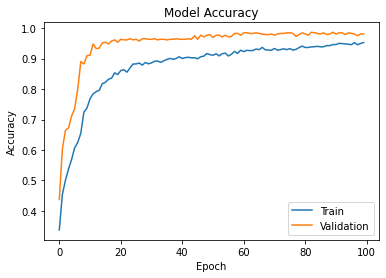

In [ ]:
#plot accuracy
import matplotlib.pyplot as plt
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.savefig('accHigh')

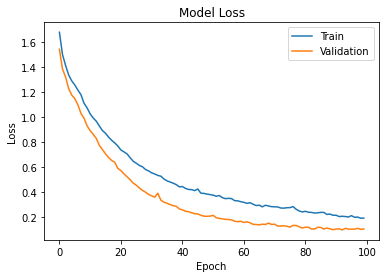

In [ ]:
# # Plot loss
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.savefig('lossHigh1.png')

In [ ]:
!cp -r "/content/Numpy Arrays/weights"  "/content/drive/Shareddrives/Major project/Major Project/Human Activity Recognition on Yoga Dataset"

In [ ]:
#Code for confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(519, 4, 16, 132) (519, 6)


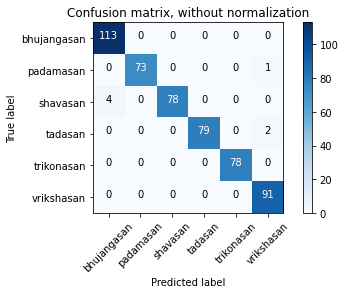

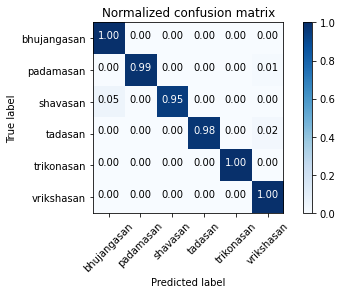

In [ ]:
trainX=np.load("trainXFinal.npy")
trainY=np.load("trainYFinal.npy")
testX=np.load("testXFinal.npy")
testY=np.load("testYFinal.npy")
trainY = to_categorical(trainY)
testY = to_categorical(testY)
num_ts, num_features, num_outputs = trainX.shape[1], trainX.shape[2], trainY.shape[1]
num_step, num_len = 4, 16
model = get_model(num_len,num_features,num_outputs)
model.load_weights("/content/Numpy Arrays/weights/val1-83-0.9865.hdf5")
testX = testX.reshape((testX.shape[0], num_step, num_len, num_features))
print(testX.shape,testY.shape)
preds = model.predict(testX)
asanas = {0:'bhujangasan', 1:'padamasan', 2:'shavasan', 3:'tadasan', 4:'trikonasan', 5:'vrikshasan'}
class_names=[]
for k in range(6):
  class_names.append(asanas[k])
Y_asanas = np.argmax(preds, axis = 1)
Y_pred_asanas = np.argmax(testY, axis = 1)
cnf_matrix = confusion_matrix(Y_asanas, Y_pred_asanas)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.savefig('confHighFrame')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.savefig('nconfHighFrame')